# BADS Exercise 8 on ensemble learning
This exercise revisits some of the concepts covered in [Tutorial 8 on ensemble learning](https://github.com/Humboldt-WI/bads/blob/master/tutorials/8_nb_ensemble_learning.ipynb). We will take a close look at bagging and analyze its impact on the predictive accuracy, and implement one of the boosting algorithms, Adaboost.

## Loading the data 
Fo this tutorial, we will use HMEQ credit risk data available at [our GitHub repo](https://github.com/Humboldt-WI/bads/blob/master/data/hmeq_prepared.csv). By now, you have imported different data sets multiple times in previous tutorials, but this step is always necessary when working with data. Your preliminary task is to load the HMEQ data set into a `pandas DataFrame`.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np

# Load the data from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_modeling.csv' 
df       = pd.read_csv(data_url, index_col = 'index')

# encode target variable
df['BAD'] = df['BAD'].astype(int) 
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,DELINQcat_1,DELINQcat_1+
index,,,,,,,,,,,,,,,,,,,
0,1,-1.832283,-1.295882,-1.335526,0.266788,-1.075278,-0.065054,-1.297476,0.137456,True,1,0,0,1,0,0,0,0,0
1,1,-1.810666,-0.013474,-0.672699,-0.236615,-0.723092,-0.826792,-0.756608,0.137456,True,1,0,0,1,0,0,0,0,1
2,1,-1.789048,-1.654549,-1.839275,-0.668103,-0.368769,-0.065054,-1.189302,0.137456,True,1,0,0,1,0,0,0,0,0
3,1,-1.789048,-0.159552,-0.202559,-0.236615,-0.061033,-0.065054,-0.107566,0.137456,True,0,1,0,1,0,0,0,0,0
4,0,-1.767431,0.791699,0.311107,-0.811933,-1.088528,-0.826792,-0.756608,0.137456,True,1,0,1,0,0,0,0,0,0


Now we can proceed to the tasks on ensemble learning!

## Tasks

### Task 1

Ensemble learning works by reducing bias and/or variance. We begin with examining the variance component. 

In the first task, you will write code that trains and tests a classifier multiple times on different subsets of HMEQ data and examines the classifier preformance. We prepared two versions of this task: *simple* and *for the experts*. Read the task description below and proceed with the version you feel ready to tackle!

*Simple version:* set up a loop to sample the data, calling the sklearn function `train_test_split()` multiple times in a loop. You can use either logistic regression or a decision tree as a classifier. Train and test a new classifier on the sampled data in each iteration of the loop and compute its AUC on the test set. Run your code for 100 iterations and visualize the variation in AUC performance by means of a boxplot. Briefly discuss your findings.

In [ ]:
# Import relevant libraries
from sklearn.model_selection import train_test_split # data partitioning
from sklearn.tree import DecisionTreeClassifier      # decision tree
from sklearn.linear_model import LogisticRegression  # logistic regression
from sklearn.metrics import roc_auc_score            # AUC metric

# Placeholder for storing AUC values
aucs = []

# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis = 1) 
y = df[['BAD']]

# Parameters
num_iters   = 100   # number of sampling iterations
test_size   = 0.3   # size of test sample (percentage)
random_seed = 2020  # random seed

# Sampling loop
for i in range(num_iters):

    # Split data into training and test. Note that we set random seed to a different 
    # integer value in each repitition - otherwise we would get the same partitioning!
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size    = test_size, 
                                                        random_state = random_seed + i)

    # Fit model on training sample
    model = DecisionTreeClassifier()  # we will use default parameters of DT
    model.fit(X_train, y_train)

    # Predict target on test sample (use probabilities)
    y_pred = model.predict_proba(X_test)[:, 1]

    # Compute and store AUC
    auc = roc_auc_score(y_test, y_pred)
    aucs.append(auc)

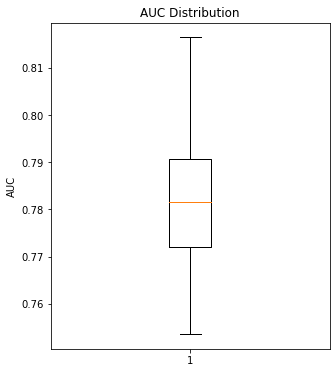

In [ ]:
# Plotthe resulting AUC values
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5, 6))
plt.boxplot(aucs)
plt.title('AUC Distribution')
plt.ylabel('AUC')
plt.show()

# The AUC values vary between 0.75 and 0.82, which is a wide range. Median AUC is 
# a little below 0.78. All this variance comes from random sampling of the training and 
# the test sample, which implies that changing a sample that we work with can have 
# a strong impact on the model and its performance. The same classifier can have a 
# very different AUC once the training data is sampled! This is important to keep in mind
# and emphasizies why data partitioning is crucial.

*For the experts:* perform the same task as above but wrap your code in a function `examine_variance()` that:
- supports both logit and decision tree as a classifier
- allows to specify the number of iterations and test sample size
- facilitates controlled sampling of the data such that you randomize either the training or the test set or both sets in each iteration. The idea is that your code should let you study the isolated effect of randomizing only the training data while always predicting the same test data, or the isolated effect of applying the same model to multiple randomized test sets, or the overall effect of sampling the data just as in the simple version
- returns a list of AUC values from each iteration

Run your function for 100 iterations and visualize the AUC values using a boxplot. Briefly discuss differences between the AUC variance when randomizing the training data, the test data or both. 


In [ ]:
# Let's first define a helper function for randomly sampling data. We will reuse
# the function `bootstrapping()` introduced in the tutorial and implement one 
# modification to it in order to allow a user specifying the random seed. This is 
# important to ensure that the sampling varies from one iteration to another, 
# and the results can be reproduced when rerunning the code. 
# We can then apply this function to randomize the data.

def bootstrapping(X, y, n_bootstrap, seed = 1):
  
    '''
    Takes a random set of observations of the size n_bootstrap.
    Returns a sample X, y.
    '''

    # Set random seed
    np.random.seed(seed)

    # Extract bootstrap indices
    bootstrap_indices = np.random.randint(low = 0, high = len(X), size = n_bootstrap) 

    # Split data
    X_bootstrapped = X.iloc[bootstrap_indices]
    y_bootstrapped = y.iloc[bootstrap_indices]
    
    # Output
    return X_bootstrapped, y_bootstrapped

In [ ]:
# Before we proceed further, let's import another useful Python library - tqdm.
# tqdm is useful for displaying visual feedback when running loops. Wrapping any  
# loop in tqdm - e.g., changing `for i in range(n)` to `for i in tqdm(range(n))` -  
# will automatically print a progress bar that updates while the loop is executing 
# in the cell and displays the elapsed time. You will see how we use it in the next cell.
from tqdm import tqdm

In [ ]:
# Now let's define a wrapper function for the task
def examine_variance(X, y,                 # input data
                     model,                # sklearn classifier
                     iterations   = 100,   # number of iterations
                     test_size    = 0.3,   # size of test sample
                     random_train = True,  # whether to sample training data
                     random_test  = True,  # whether to sample test data 
                     seed         = 1):    # random seed
  

    '''
    Implements a custom classifier model on random train/test sample of the data.
    Returns list with the AUC values.
    '''

    # Placeholder for AUC
    aucs = []

    # First, let's partition the data outside of the loop using `train_test_split()`
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size    = test_size, 
                                                        random_state = seed)

    # Modeling loop wrapped in tqdm for displaying the progress bar
    for i in tqdm(range(iterations)):

        # Randomize training data if needed
        if random_train:
            X_train_sample, y_train_sample = bootstrapping(X           = X_train, 
                                                           y           = y_train,
                                                           n_bootstrap = len(X_train),
                                                           seed        = seed + i)
        else:
            X_train_sample, y_train_sample = X_train.copy(), y_train.copy()

        # Randomize test data if needed
        if random_test:
            X_test_sample, y_test_sample = bootstrapping(X           = X_test, 
                                                         y           = y_test,
                                                         n_bootstrap = len(X_test),
                                                         seed        = seed + i)
        else:
            X_test_sample, y_test_sample = X_test.copy(), y_test.copy()

        # Fit model on training sample
        model.fit(X_train_sample, y_train_sample)

        # Predict target on test sample
        y_pred = model.predict_proba(X_test_sample)[:, 1]

        # Compute and store AUC
        auc = roc_auc_score(y_test_sample, y_pred)
        aucs.append(auc)

    # Output AUC values
    return aucs

In [ ]:
# Specify the base model (random_state make sure results can be reproduced)
model = DecisionTreeClassifier(random_state = 2020, 
                               max_depth    = 5)

# Run three variants of our function: with random train, test and both samples
aucs_0 = examine_variance(X, y,    
                          model        = model, 
                          iterations   = 100,  
                          test_size    = 0.3,  
                          random_train = True, 
                          random_test  = False, 
                          seed         = 777)

aucs_1 = examine_variance(X, y,    
                          model        = model, 
                          iterations   = 100,  
                          test_size    = 0.3,  
                          random_train = False, 
                          random_test  = True, 
                          seed         = 777)

aucs_2 = examine_variance(X, y,    
                          model        = model, 
                          iterations   = 100,  
                          test_size    = 0.3,  
                          random_train = True, 
                          random_test  = True, 
                          seed         = 777)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 49.19it/s]


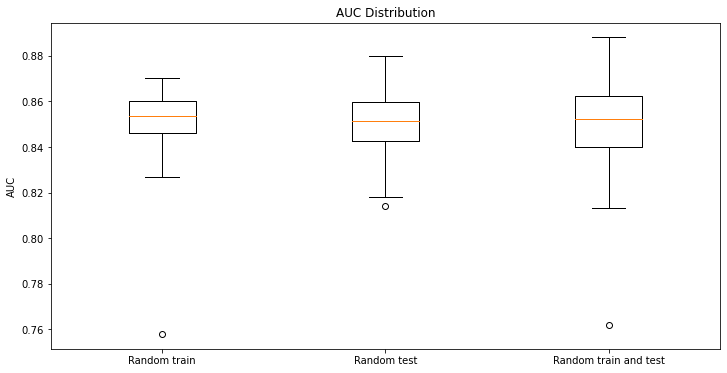

In [ ]:
# Let's build boxplots and compare the results!

fig = plt.figure(figsize = (12, 6))

plt.boxplot([aucs_0, aucs_1, aucs_2])
plt.title('AUC Distribution')
plt.ylabel('AUC')
plt.xticks(ticks  = [1, 2, 3], 
           labels = ['Random train', 'Random test', 'Random train and test'])
plt.show()

In [ ]:
# The results suggest that randomizing both training and test sample results in 
# the largest variance of the AUC values: the AUC fluctuates between about 0.81 
# and 0.89. Randomizing only train or only test sample results in a lower 
# variance of the model performance. It is interesting to note that randmoizing 
# test sample has a stronger effect on the variance of AUC comapred to the training 
# data.

### Task 2

Implement a bagged logistic regression classifier from scratch. You can use the `sklearn` class `LogisticRegressionClassifier` for implementing the base model. The actual bagging step, however, should be implemented from scratch

In [ ]:
# We will define a function `bagged_classifier()` that will use the previously 
# defined `bootstraping()` function to randomize training sample multiple times
# and then train a model on each of the bootstrapped samples. Next, we will average
# predictions from individual models to get predictions of the bagged classifier.

def bagged_classifier(X_train,            # training data (features)
                      y_train,            # training data (target)
                      X_test,             # test data (features)
                      model,              # sklearn model
                      num_samples = 100,  # number of bootstrap samples
                      seed        = 1):   # random seed

    '''
    Implements a bagged logistic regression classifier.
    Returns classifier predictions.  
    '''

    # Predictions placeholder
    y_pred = np.zeros((len(X_test), num_samples))

    # Modeling loop
    for i in range(num_samples):

        # Subsample training data with a new random seed
        X_train_sample, y_train_sample = bootstrapping(X           = X_train, 
                                                       y           = y_train, 
                                                       n_bootstrap = num_samples,
                                                       seed        = seed + i)

        # Fit model on training sample. Providing `np.ravel(y)` instead of `y` as 
        # a target helps to avoid a warning message of `LogisticRegression()` that 
        # expects to see the target variable in this format. The code will execute 
        # without `np.ravel()` with the same result but will display a warning that
        # we would like to avoid.
        model.fit(X_train_sample, np.ravel(y_train_sample))

        # Predict target on test sample
        y_pred[:, i] = model.predict_proba(X_test)[:, 1]

    # Average predictions
    y_pred = np.mean(y_pred, axis = 1)

    # Output
    return y_pred

In [ ]:
# Let's quickly test our function on the previously partitioned HMEQ data to make
# sure there are no errors
preds = bagged_classifier(X_train     = X_train,
                          y_train     = y_train,
                          X_test      = X_test,
                          model       = LogisticRegression(),
                          num_samples = 10)
preds[0:3]

array([0.19049027, 0.1979073 , 0.10569838])

### Task 3

Theory predicts that bagging should work better for unstable base models like trees than for stable base models like logistic regression. Use the custom bagging algorithm developed in Task 2 to verify this assertion for the HMEQ loan dataset. Specifically:
  - chose a proper experimental design to compare models (split-sample or cross-validation)
  - train two simple classifiers: 
    - logistic regression
    - decision tree
  - train two bagging classifiers:
      - bagged logistic regression
      - bagged decision tree
  - both bagging classifiers should use your custom bagging function from Task 2
  - compare the predictive performance of the bagging ensembles on the test data and briefly discuss your findings

In [ ]:
# For simplicity, let's perform our experiment using a single split-sample partitioning. 
# First, we will create the new partitioning of the HMEQ data. Next, we will proceed
# to implementing the classifiers.

# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis = 1) 
y = df[['BAD']]

# Split sample parameters
test_size   = 0.3  # size of test sample (percentage)
random_seed = 815  # random seed

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size    = test_size, 
                                                    random_state = random_seed)

In [ ]:
# Let's create a dataframe for storing predictions from our classifiers
preds = pd.DataFrame(columns = ['LR', 'DT', 'BagLR', 'BagDT'])

# We will start with fitting single models, LR and DT, and storing their predictions
# in the `preds` dataframe.
model_lr = LogisticRegression(random_state     = random_seed)
model_dt = DecisionTreeClassifier(random_state = random_seed)
model_lr.fit(X_train, np.ravel(y_train))
model_dt.fit(X_train, y_train)
preds['LR'] = model_lr.predict_proba(X_test)[:, 1]
preds['DT'] = model_dt.predict_proba(X_test)[:, 1]

# Now let's implement a bagged logistic regression
preds['BagLR'] = bagged_classifier(X_train     = X_train,
                                   y_train     = y_train,
                                   X_test      = X_test,
                                   model       = model_lr,
                                   num_samples = 100)

# Finaly, we train a bagged decision tree
preds['BagDT'] = bagged_classifier(X_train     = X_train,
                                   y_train     = y_train,
                                   X_test      = X_test,
                                   model       = model_dt,
                                   num_samples = 100)

# Print performance values
print('- single LR AUC = {:.4f}'.format(roc_auc_score(y_test, preds['LR'])))
print('- bagged LR AUC = {:.4f}'.format(roc_auc_score(y_test, preds['DT'])))
print('- single DT AUC = {:.4f}'.format(roc_auc_score(y_test, preds['BagLR'])))
print('- bagged DT AUC = {:.4f}'.format(roc_auc_score(y_test, preds['BagDT'])))

- single LR AUC = 0.7819
- bagged LR AUC = 0.7819
- single DT AUC = 0.7734
- bagged DT AUC = 0.8859


In [ ]:
# The results confirm our expectation. The AUC of LR increases from 0.7653 to 
# 0.7923 when adding bagging, which is a gain of 0.0270.
# The DT has a much stronger benefit from bagging of 0.137! This goes agrees  
# with theory. Unstable models like DT should benefit more from bagging than  
# stable models like LR.

# Note that this does not mean that our intuition is always right and DT will always benefit
# from bagging more than LR. The result we observe is valid for the HMEQ dataset 
# but could be different for another dataset or even another partitioning of the HMEQ data 
# (recall that we only used a single split-sample in our experiment). In Task 4, 
# we will check the robustness of our observations by running the experiment on multiple data splits.

### Task 4 [optional]

#### 4.1. Further enhance the analysis from Task 3 as follows:
  - repeat the comparison of bagged logit versus bagged trees multiple times with different training and testing data sets
  - depict the results (predictive performance) as a boxplot

In [ ]:
# To complete this task, let's first wrap our experiment from Task 3 into a function 
# `compare_classifiers()` that we can then run on different data partitionings.

def compare_classifiers(X, y,
                        test_size   = 0.3,
                        num_samples = 100,
                        num_repeats = 10,  # number of data splits to repeat experiment
                        seed        = 1):

    '''
    Fits bagged classifiers and tests their performance.
    Returns a list with AUC values.
    '''

    # Dataframe for storing predictions from our classifiers
    aucs = pd.DataFrame(columns = ['LR', 'DT', 'BagLR', 'BagDT'])

    # Repeat with different splits
    for i in range(num_repeats):

        # Feedback
        print('- processing partitioning {}...'.format(i + 1))

        # Partition the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size    = test_size, 
                                                            random_state = seed + i)

        # Dataframe for storing predictions from our classifiers
        preds = pd.DataFrame(columns = ['LR', 'DT', 'BagLR', 'BagDT'])

        # Fit and predict with single models
        model_lr = LogisticRegression(random_state     = seed)
        model_dt = DecisionTreeClassifier(random_state = seed)
        model_lr.fit(X_train, np.ravel(y_train))
        model_dt.fit(X_train, y_train)
        preds['LR'] = model_lr.predict_proba(X_test)[:, 1]
        preds['DT'] = model_dt.predict_proba(X_test)[:, 1]

        # Bagged logistic regression
        preds['BagLR'] = bagged_classifier(X_train     = X_train,
                                           y_train     = y_train,
                                           X_test      = X_test,
                                           model       = model_lr,
                                           num_samples = num_samples)

        # Bagged decision tree
        preds['BagDT'] = bagged_classifier(X_train     = X_train,
                                           y_train     = y_train,
                                           X_test      = X_test,
                                           model       = model_dt,
                                           num_samples = num_samples)

        # Save performance
        aucs.loc[i, 'LR']    = roc_auc_score(y_test, preds['LR'])
        aucs.loc[i, 'DT']    = roc_auc_score(y_test, preds['DT'])
        aucs.loc[i, 'BagLR'] = roc_auc_score(y_test, preds['BagLR'])
        aucs.loc[i, 'BagDT'] = roc_auc_score(y_test, preds['BagDT'])

    # Output
    return aucs

- processing partitioning 1...
- processing partitioning 2...
- processing partitioning 3...
- processing partitioning 4...
- processing partitioning 5...
- processing partitioning 6...
- processing partitioning 7...
- processing partitioning 8...
- processing partitioning 9...
- processing partitioning 10...


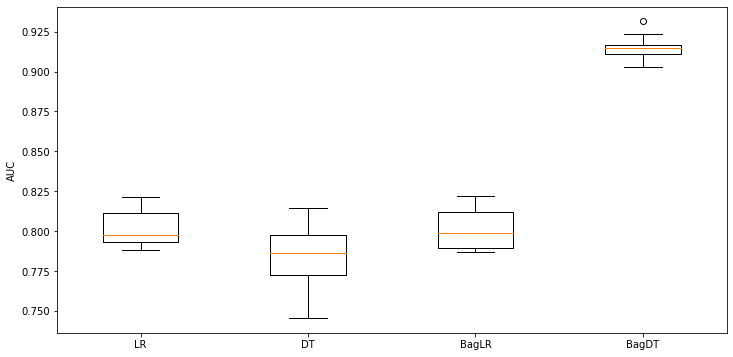

In [ ]:
# Perform experiment [takes some time!]
aucs = compare_classifiers(X, y, 
                           test_size   = 0.3,
                           num_samples = 200,
                           num_repeats = 10,
                           seed        = 2020)

# Visualize results
fig = plt.figure(figsize = (12, 6))
plt.boxplot(aucs.values)
plt.ylabel('AUC')
plt.xticks(ticks  = [1, 2, 3, 4], 
           labels = aucs.columns)
plt.show()

In [ ]:
# The results obtained in Task 3 seem to be robust: the ranking of the classifiers 
# remains stable even after 10 repetitions with different train and test splits.

# Overall, we still observe that the AUC gain from bagging is higher for the tree.
# We can also note that the bagged version of the DT has lower variance 
# compared to a single decision tree. This is to be expected because we grow a
# tree with no limit on the `max_depth` parameter, which makes a single tree likely 
# to overfit the training sample. Bagging helps to fight overfitting by building such
# trees on multiple different training sample, which leads to a classifier with lower
# variance and better performance. This is a clear win!

### 4.2. Investigate the impact of the ensemble size:
- try out different settings for the hyperparameter *ensemble size* (number of bagging iterations)
- produce a line plot of predictive performance versus ensemble size for bagged logit and bagged tree
- identify the suitable ensemble size for both classifiers  

In [ ]:
# A simple way to proceed with this task is to set up a loop where we can implement
# our bagged classifier with different `num_samples`. However, this would be inefficient:
# imagine that we need to iteratively train (1, 2, ..., n) base models on each step of
# such a loop, which will result in training a total of 1 + 2 + ... + n base models. 
# What we can do instead is to train ONE bag classifier with n base models and extract 
# a matrix with individual base model predictions instead of a vector with the averaged 
# predictions. Then, we can simply aggregate predictions from a different number 
# of base models without the need to train a new bagged classifier every time. 

# Let's modify our bagging function to return a matrix with all predictions. We 
# introduce an argument `return_all_preds` for this purpose.

def bagged_classifier(X_train,                   # training data (features)
                      y_train,                   # training data (target)
                      X_test,                    # test data (features)
                      model,                     # sklearn model
                      num_samples      = 100,    # number of bootstrap samples
                      seed             = 1,      # random seed
                      return_all_preds = False): # return matrix with individual predictions

    '''
    Implements a bagged classifier.
    Returns classifier predictions.  
    '''

    # Predictions placeholder
    y_pred = np.zeros((len(X_test), num_samples))

    # Modeling loop with tqdm for displaying the progress bar
    for i in tqdm(range(num_samples)):

        # Subsample training data with a new random seed
        X_train_sample, y_train_sample = bootstrapping(X           = X_train, 
                                                       y           = y_train, 
                                                       n_bootstrap = num_samples,
                                                       seed        = seed + i)

        # Fit model on training sample
        model.fit(X_train_sample, np.ravel(y_train_sample))

        # Predict target on test sample
        y_pred[:, i] = model.predict_proba(X_test)[:, 1]

    # Average predictions
    if not return_all_preds:
        y_pred = np.mean(y_pred, axis = 1)

    # Output
    return y_pred

In [ ]:
# Now let's perform the experiment! First, we specify the max ensemble size
ensemble_size = 500

# Specify base models
model_lr = LogisticRegression(random_state     = random_seed)
model_dt = DecisionTreeClassifier(random_state = random_seed)

# Bagged logistic regression
preds_bag_lr = bagged_classifier(X_train          = X_train,
                                 y_train          = y_train,
                                 X_test           = X_test,
                                 model            = model_lr,
                                 num_samples      = ensemble_size,
                                 return_all_preds = True)

# Bagged decision tree
preds_bag_dt = bagged_classifier(X_train          = X_train,
                                 y_train          = y_train,
                                 X_test           = X_test,
                                 model            = model_dt,
                                 num_samples      = ensemble_size,
                                 return_all_preds = True)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 150.57it/s]


In [ ]:
# Now we can evaluate the performance. Let's first set up placeholders for AUC values
aucs_lr = []
aucs_dt = []

# Loop through different ensemble sizes
for n in range(1, ensemble_size + 1):

    # Extract average predictions of the first n models
    preds_lr = np.mean(preds_bag_lr[:, 0:n], axis = 1)
    preds_dt = np.mean(preds_bag_dt[:, 0:n], axis = 1)

    # Compute and store AUC values
    aucs_lr.append(roc_auc_score(y_test, preds_lr))
    aucs_dt.append(roc_auc_score(y_test, preds_dt))

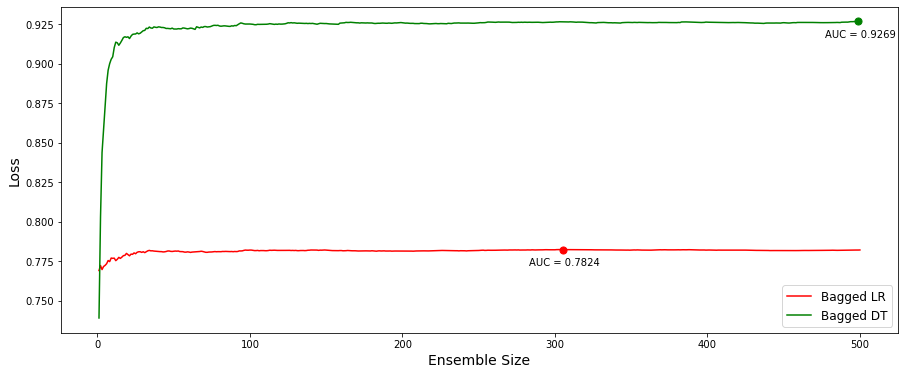

In [ ]:
# We will now create a Plot depicting the results. We will depict the curves with
# the AUC dynamics and emphasize the points with the best performance
plt.figure(figsize = (15, 6))
plt.plot(range(1, ensemble_size + 1), aucs_lr, color = 'red',   label = 'Bagged LR')
plt.plot(range(1, ensemble_size + 1), aucs_dt, color = 'green', label = 'Bagged DT') 

# find the best LR and DT AUC coordinates
x_lr = np.argmax(np.array(aucs_lr)) + 1; y_lr = max(aucs_lr)
x_dt = np.argmax(np.array(aucs_dt)) + 1; y_dt = max(aucs_dt)

# display points with the best AUC for DT and LR
plt.scatter(x_lr, y_lr, s = 50, color = 'red')    
plt.scatter(x_dt, y_dt, s = 50, color = 'green') 
xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
plt.text(x_lr - 0.04*xdist, y_lr - 0.05*ydist, 'AUC = {:.4f}'.format(y_lr), size = 10)
plt.text(x_dt - 0.04*xdist, y_dt - 0.05*ydist, 'AUC = {:.4f}'.format(y_dt), size = 10)

# axis labels and legend
plt.ylabel('Loss',          size = 14)
plt.xlabel('Ensemble Size', size = 14)
plt.legend(loc = 4, fontsize = 'large')
plt.show()

In [ ]:
# The results suggest that both classifiers benefit a lot from bagging in the beginning
# when the number of samples is still low. After the ensemble size reaches 20-30, 
# gains from adding additional base model diminish.  
# The difference between LR and DT is also striking - the AUC of DT makes a 
# huge jump when training it on just a few samples instead of a single one. Bagged DT 
# reaches the best performance with the ensemble size of 95 and does not benefit 
# from further increases of the number of models. On the other hand, bagged LR 
# continues to improve and reaches the highest AUC at 305 samples. It is also useful
# to note that larger ensemble size does not lead to a visible deterioration of the
# performance, so it might be better to "overshoot" and go for a larger ensemble 
# instead of settling on a too small number of samples for LR.

### Task 5
Write a custom Python function that implements the *Adaboost* algorithm. Follow the pseudo-code of the algorithm, as shown in the lecture materials. Design your function such that it accepts a `sklearn` model object as argument and than runs Adaboost using the corresponding base classifier. Test your function on the HMEQ data and evaluate performance in terms of AUC.

In [ ]:
# Since we would like our `adaboost()` function to accept a sklearn model as input,
# it would be useful to import `deepcopy` function from `copy` library. This will
# help us to create a new copy of a classifier object on each boosting iteration
# to nake sure we can store classifiers from all iterations in memory to compute 
# predictions after the algorithm has finished. Note that we did not use this in 
# previous tasks when we were extracting predictions from each base classifier immediately
# after training it without the need to store each classifier in memory. 
from copy import deepcopy

# Let's define `adaboost()` function that implements the Adaboost classifier
def adaboost(X_train,    # training data (features)
             y_train,    # training data (target)
             X_test,     # test data (features)
             model,      # base model (sklearn object) 
             T    = 100, # number of boosting iterations
             seed = 1):  # random seed
  
    '''
    Implements Adaboost classifier.
    Returns vector of predictions.
    '''
  
    # First, we need to convert target values to {-1, 1} as required by the algorithm
    y_train_enc = y_train['BAD'].map({1: 1, 0: -1})
    y_train_enc = np.ravel(y_train_enc)

    # Initialize equal sample weights
    w = np.repeat(1 / len(X_train), len(X_train))

    # Placeholder for classifiers and their weights
    stumps        = []
    stump_weights = []

    # Repeat training and weights update for T iterations
    for t in tqdm(range(T)):

        # Fit classifier with sample weights
        # We copy classifier in memory using `deepcopy()`
        stump = deepcopy(model)
        stump.fit(X             = X_train, 
                  y             = y_train_enc,
                  sample_weight = w)
        
        # Predict target on the training sample
        # Here, we predict classes and not probabilities
        y_pred = stump.predict(X_train)

        # Calculate classification error
        ce = w[(y_pred != y_train_enc)].sum()

        # Calculate classification weight
        stump_weight = 0.5 * np.log((1 - ce) / ce)

        # Update sample weights
        w = w * np.exp(-stump_weight * y_train_enc * y_pred)
        w = w / w.sum()

        # Save classifiers
        stumps.append(stump)
        stump_weights.append(stump_weight)

    # Output test predictions - again, we predict classes instead of probs
    stump_preds = np.array([stump.predict(X_test) for stump in stumps])
    preds       = np.sign(np.dot(stump_weights, stump_preds))
    return preds

In [ ]:
# Implement adaboost with DT. Note that we specify a (relatively) weak base model
# as a decision tree with the maximum depth of 3. Using a complex model that fits the
# training data perfectly would not work as the error of such model would be zero.
# too weak learner can also result in a worse performance or require large ensemble 
# size to reach the same level of performance. You can experiment with different depth 
# to see how the AUC of Adaboost reacts to this hyperparameter.
preds_adaboost = adaboost(X_train = X_train,
                          y_train = y_train,
                          X_test  = X_test,
                          model   = DecisionTreeClassifier(max_depth = 3),
                          T       = 500,
                          seed    = 1)

# Check performance
print('')
print('AUC = {:.4f}'.format(roc_auc_score(y_test, preds_adaboost)))

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 63.31it/s]



AUC = 0.8379


# Well done! Your ensembles performed great!